In [2]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [3]:
import numpy as np
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt

from detection.inference.detector import lesion_detector, post_process_pred

# Predict for test set

In [14]:
#### inputs (editable)
split_name = 'split_1_old'
metric_name = 'AUFROC'
####

# model inputs
config_file = repo_path / 'detection/training/config_files/fine_tuning_CEM.yaml'
min_score = 0.1 # minimum score threshold to keep the prediction

# validation data inputs
im_dir = repo_path / 'data/CDD-CESM/images/substracted' # images directory (can contain other not only test)
metadata_path = repo_path / f'data/CDD-CESM/metadata/bboxes/{split_name}/test_set.csv' # test data only

# get best models of the split
best_models_csv_path = repo_path / 'detection/evaluation/data/validation' / f'{split_name}/best_models/best_models_{metric_name}.csv'
best_models_csv = pd.read_csv(best_models_csv_path)
split_dir = repo_path / f'detection/training/results/{split_name}'

# saving directory
testing_split_dir = repo_path / 'detection/evaluation/data/testing' / f'{split_name}'
testing_split_dir.mkdir(parents=True, exist_ok=True)

for i, row in best_models_csv.iterrows():
    model_path = split_dir / row['model_type'] / f'{row["model_name"]}.pth'
    detector = lesion_detector(config_file, model_path, metadata_path, im_dir, min_score)
    detector.start_metrics()
    for im_name in detector.test_df['image_name'].unique()[0:]:
        detector.c_im_name = im_name
        detector.prepare_im_gt()
        detector.predict()
        # detector.show_c_predictions()
        # metrics computing
        used_preds = detector.compute_TP_FN_counts(show=False)
        detector.compute_FP_counts(used_preds)
    froc_info  = detector.compute_FROC()
    froc_info.to_csv(testing_split_dir / f'{row["model_type"]}.csv', index=False)

[03/06 23:42:25 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/detection/training/results/split_1_old/real-synth_fine-tuning/model_0019999.pth ...
[03/06 23:42:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/detection/training/results/split_1_old/synthetic_improved/model_0024999.pth ...
[03/06 23:42:38 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/detection/training/results/split_1_old/real-synth_improved/model_0024999.pth ...
[03/06 23:42:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/detection/training/results/split_1_old/normal_fine-tuning/model_0029999.pth ...
[03/06 23:42:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/detection/training/results/split_1_old/synthetic/model_

# Metrics for test results

In [38]:
def computing_sensitivity_at_FPpI(froc_info):
    # compute sensitivity at:
    # sen_at = [1/4, 2/4, 3/4, 1]
    sen_at = [0.25, 0.5]
    sensitivity_df = None
    for FPpI in sen_at:
        c_sen = np.interp(x=FPpI, xp=froc_info['FPpI'], fp=froc_info['TPR'])
        c_sen_df = pd.DataFrame({'FPpI': [FPpI], 'sensitivity': [c_sen]})
        sensitivity_df = pd.concat([sensitivity_df, c_sen_df], ignore_index=True)

    average_sen = sensitivity_df['sensitivity'].mean()
    return sensitivity_df, average_sen
    
def AUFROC_computing(froc_info, FPpI_limit=1.0):
    """compute the FROC area under the curve.
    By thefault the AUC is computed up to 1 FPpI, if the limit is surpassed, the curve is cut at the limit.

    Args:
        froc_info (_type_): _description_
        FPpI_limit (float, optional): _description_. Defaults to 1.0.

    Returns:
        float: AUC value
    """ 
    # check if the FPpI limit is reached
    if froc_info['FPpI'].max() < FPpI_limit:
        # add a point to reach the limit, adding a row
        froc_info = pd.concat([froc_info, pd.DataFrame({'FPpI': [FPpI_limit], 'TPR': [froc_info['TPR'].iloc[-1]]})], ignore_index=True)
    # check if the FPpI limit is surpassed
    elif froc_info['FPpI'].max() > FPpI_limit:
        # remove points that surpass the limit
        froc_info = froc_info[froc_info['FPpI'] <= FPpI_limit]
        # add a point to reach the limit, adding a row
        froc_info = pd.concat([froc_info, pd.DataFrame({'FPpI': [FPpI_limit], 'TPR': [froc_info['TPR'].iloc[-1]]})], ignore_index=True)

    # compute the area under the curve using the trapezoidal rule
    AUC_value = np.trapz(froc_info['TPR'], x=froc_info['FPpI'])

    return AUC_value

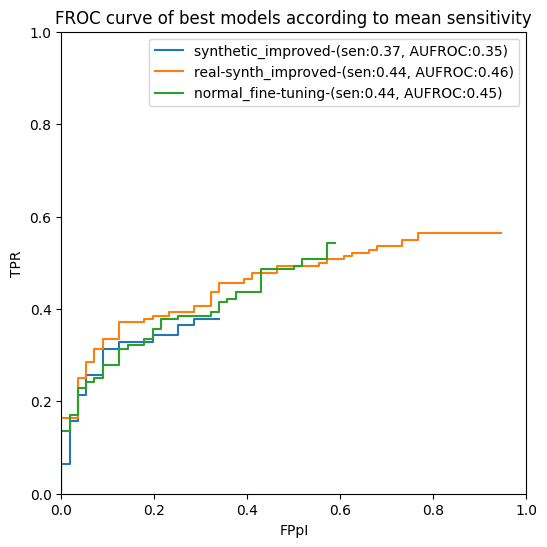

In [40]:
FPpI_limit = 1
split_name = 'split_1'
###
split_pred_dir = repo_path / 'detection/evaluation/data/testing' / f'{split_name}'
# get all the csv files
csv_pred_paths = [f for f in split_pred_dir.glob('*.csv') if f.is_file()]

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel('FPpI')
ax.set_ylabel('TPR')
ax.set_title('FROC curve of best models according to mean sensitivity')
# set TPR limits
ax.set_ylim(0,1)
ax.set_xlim(0,FPpI_limit)

for csv_path in csv_pred_paths:
    froc_info = pd.read_csv(csv_path)
    sensitivity_df, average_sen = computing_sensitivity_at_FPpI(froc_info)
    aufroc = AUFROC_computing(froc_info, FPpI_limit)
    ax.plot(froc_info['FPpI'], froc_info['TPR'], marker='',
            label=f'{csv_path.stem}-(sen:{average_sen.round(2)}, AUFROC:{aufroc.round(2)})',
            linestyle='-', linewidth=1.5)    
    
ax.legend()

In [34]:
sen_comparison

,FPpI,real-synth_fine-tuning,FPpI,synthetic_improved,FPpI,real-synth_improved,FPpI,normal_fine-tuning,FPpI,synthetic
0,0.25,0.428571,0.25,0.321429,0.25,0.464286,0.25,0.421429,0.25,0.321429
1,0.50,0.535714,0.50,0.371429,0.50,0.521429,0.50,0.557143,0.50,0.342857
2,0.75,0.585714,0.75,0.371429,0.75,0.600000,0.75,0.592857,0.75,0.342857
3,1.00,0.585714,1.00,0.371429,1.00,0.621429,1.00,0.600000,1.00,0.342857
